### 0. 필요한 라이브러리 Import

In [1]:
import os
import pandas as pd
import pandas_profiling
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from gensim.models.word2vec import Word2Vec
import nltk
import time
from pykospacing import spacing
import re

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

import kss
#from konlpy.tag import Kkma  
from konlpy.tag import Twitter
from eunjeon import Mecab
from konlpy.tag import Okt

# %appdata%\nltk_data\corpora\stopwords
# korean 파일을 생성하여 복사함
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

#nltk.download('stopwords')

np.random.seed(42)

twitter = Twitter()
#kkma = Kkma()
mecab = Mecab('C://mecab//mecabrc')
okt = Okt()


# 한글출력
#matplotlib.rc('font', family='AppleGothic')  # MacOS
matplotlib.rc('font', family='Malgun Gothic')  # Windows
plt.rcParams['axes.unicode_minus'] = False

### 1. 통합된 원본 데이터 파일을 읽어온다

In [2]:

ROOT_DIR = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
dataset = pd.read_csv(os.path.join(ROOT_DIR, "dataset/one.csv"))

print(dataset.shape)
print(dataset.info())

(50568, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50568 entries, 0 to 50567
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   제목                              50568 non-null  object 
 1   저자                              50568 non-null  object 
 2   발행기관                            50568 non-null  object 
 3   학술지명                            50568 non-null  object 
 4   권호사항                            50568 non-null  object 
 5   발행연도                            50568 non-null  int64  
 6   작성언어                            50568 non-null  object 
 7   주제어                             26933 non-null  object 
 8   KDC                             11761 non-null  float64
 9   등재정보                            13083 non-null  object 
 10  자료형태                            50568 non-null  object 
 11  발행기관 URL                        22715 non-null  object 
 12  수록면                 

In [3]:
dataset.head()

,제목,저자,발행기관,학술지명,권호사항,발행연도,작성언어,주제어,KDC,등재정보,...,발행기관 URL,수록면,KCI 피인용횟수,비고,중단사유,제공처,소장기관,국문 초록 (Abstract),다국어 초록 (Multilingual Abstract),목차
0,전기 이륜자동차 분류기준 현황 : 자동차관리법 중심,정윤재,한국자동차공학회,한국자동차공학회 Workshop,Vol.2011No.9[2011]\r\n,2011,Korean,NaN,556.0,NaN,...,http://www.ksae.org,1-14,NaN,NaN,NaN,DBpia,NaN,NaN,NaN,NaN
1,자동차 사회의 환경과 에너지 문제 = 자동차 엔진 기술의 역사적 동향,김영길(Yong Kil Kim),한국자동차공학회,한국자동차공학회 학술대회 및 전시회,Vol.2014No.11[2014]\r\n,2014,Korean,"Internal Combustion Engine(내연기관),Energy (에너지),...",NaN,NaN,...,NaN,1477-1477,NaN,NaN,NaN,DBpia,NaN,NaN,NaN,NaN
2,수소 연료전지 자동차의 충돌 및 화재안전성 관련 연구동향 = Trends on Cr...,"임재문(Jae Moon Lim),장형진(Hyung Jin Chang),김규현(Gyu...",한국자동차공학회,한국자동차공학회 춘 추계 학술대회 논문집,Vol.-No.-[2008]\r\n,2008,Korean,"Hydrogen Fuel Cell Vehicle(수소 연료전지 자동차),Crash ...",NaN,NaN,...,http://www.ksae.org,1253-1258,NaN,NaN,NaN,DBpia,NaN,환경문제에 따른 배기가스 배출저감 및 자원고갈에 따른 대안으로 향후 수소 연료전지 ...,The researches on the crash and the fire safet...,Abstract\n1. 서론\n2. 수소의 특성\n3. 충돌 및 화재안전성 관련 연...
3,차세대 자동차 개발의 Plastic Hood 설계 및 CAE해석 = Plastic ...,"황태원(Taewon Hwang),최치훈(Chihoon Choi),박상선(Sangsu...",한국자동차공학회,한국자동차공학회 춘 추계 학술대회 논문집,Vol.-No.-[2006]\r\n,2006,Korean,"HOOD(본넷트),Distance(이동량),LS-DYNA(구조해석),MOLDFLOW...",NaN,NaN,...,http://www.ksae.org,2032-2032,NaN,NaN,NaN,DBpia,NaN,현재 생활 필수품 중의 하나인 자동차논 많은 변화를 보이고 있다. 발전사를 살펴보면...,NaN,NaN
4,자동차 산업의 역사와 급변하는 기술에 대응한 교육의 바람직한 방향에 관한 연구 = ...,황경수(Kyungsoo Whang),한국자동차공학회,한국자동차공학회 Workshop,Vol.2001No.-[2001]\r\n,2001,Korean,NaN,NaN,NaN,...,http://www.ksae.org,70-80,NaN,NaN,NaN,DBpia,NaN,오늘날 급속히 변화하고 있는 자동차 기술에 대응한 자동차 기술교육의 방법을 모색하여...,NaN,초록<br/>\n1.서론<br/>\n2.국내 자동차기술교육의 역사<br/>\n3.민...


In [4]:
import timeit 

In [5]:

start = time.time()

train_data = dataset['국문 초록 (Abstract)'].dropna()
train_data = train_data.apply(lambda x: re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣] ", "", x))

end = time.time()
print(f'총 소요시간:{end-start}초')

총 소요시간:0.4636838436126709초


In [6]:
#너무 오래 걸림
start = time.time()

train_data_list = []
for idx, element in enumerate(train_data.tolist()) :
    print(idx, end=",")
    r = spacing(element)
    train_data_list.append(element)


end = time.time()
print(f'총 소요시간:{end-start}초')

train_data_list
#[spacing(x) for x in train_data.tolist()]

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,

KeyboardInterrupt: 

In [8]:

print(len(train_data))

10447


사용 가능한 패키지
Soyspacing – https://github.com/lovit/soyspacing : 휴리스틱 알고리즘 기반 띄어쓰기 모델. 주어진 알고리즘으로 input으로 들어간 문장들에서 띄어쓰기 규칙을 파악하고 이를 새로운 문장에 적용. 모든 한글 문서에 광범위하게 적용할 수 있는 모델을 내기에는 한계가 있겠지만, 동질적인 주제와 형식을 가진 문서들에 대해 분석을 하는 경우 특히 유용하게 쓸 수 있을 것 같다. (특정 도메인을 위한 모델)

PyKoSpacing – https://github.com/haven-jeon/PyKoSpacing : CNN에 RNN을 쌓아 올린 모델을 뉴스 데이터로 훈련. 세종 코퍼스 등 테스트 셋에서 잘 작동한다고 한다. 하지만 accuracy measure가 성능을 over represent 할 수 있을 것 같다. 대체로 띄어쓰기가 정말 난장판으로 되어있는 경우 볼만한 문서로 바꾸는데 사용할 수 있을 것 같다.

TaKos (Alpha) – https://github.com/Taekyoon/takos-alpha : 앞서 첨부한 Youtube 영상에서 소개된 프로젝트. 아직 상용화까지 개발이 진행 중인 것 같다!

In [9]:
stop_words_kor = stopwords.words('korean')

In [10]:
tokenized_data = []

start = time.time()
for abstract in train_data.tolist() :
    temp_X = mecab.morphs(abstract)
    temp_X = [word for word in temp_X if not word in stop_words_kor]
    tokenized_data.append(temp_X)

end = time.time()
print(f'총 소요시간:{end-start}초')

총 소요시간:39.802679777145386초


초록의 최대 길이: 7395
초록의 평균 길이: 250.04010720781085


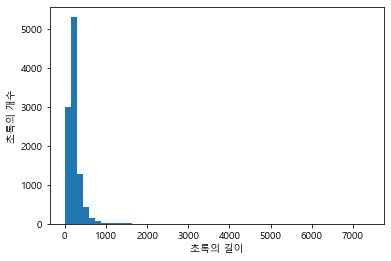

In [11]:
print('초록의 최대 길이:', max(len(l) for l in tokenized_data))
print('초록의 평균 길이:', sum(map(len, tokenized_data)) / len(tokenized_data))

plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('초록의 길이')
plt.ylabel('초록의 개수')
plt.show()

In [12]:
model = Word2Vec(sentences=tokenized_data, size=100, window=5, min_count=5, workers=4, sg=0)

In [13]:
model.wv.vectors.shape

(15592, 100)

In [14]:
print(model.wv.most_similar("자율 주행"))

[('무인', 0.7692404985427856), ('지능형 자동차', 0.765545666217804), ('스마트', 0.7417160272598267), ('지능형', 0.7375139594078064), ('ITS', 0.7306390404701233), ('원격 제어', 0.7227223515510559), ('자율 주행 자동차', 0.720944881439209), ('사물인터넷', 0.7208918929100037), ('IoT', 0.7185481786727905), ('유비쿼터스', 0.715216875076294)]


In [15]:
print(model.wv.most_similar("자율주행"))

[('자율주행자동차', 0.7227725982666016), ('자율 주행', 0.7007153034210205), ('무인', 0.6871726512908936), ('운행', 0.6519333124160767), ('인공지능', 0.6456612348556519), ('주행', 0.6266435980796814), ('운전자', 0.597837507724762), ('대포', 0.5846076607704163), ('탑승객', 0.5686014890670776), ('안전', 0.5616433620452881)]


In [32]:
print(model.wv.most_similar("하이브리드"))

[('연료전지', 0.8115795850753784), ('차세대', 0.7781344652175903), ('내연기관', 0.7568431496620178), ('EV', 0.7482553720474243), ('전기', 0.7153195738792419), ('전장', 0.7073630094528198), ('파워', 0.7033920288085938), ('전동', 0.6996391415596008), ('트레인', 0.6993821859359741), ('전지', 0.6957760453224182)]


In [ ]:
dataset['주제어']

In [ ]:
dataset['작성언어'].value_counts()

### CountVector를 위한 준비 작업 및 확인 로직 (시작)

In [4]:
#분석대상 항목으로 발행연도, 제목, 주제어, 국문 초록 (Abstract)을 선택하고 컬럼명을 영문으로 변경함
dataset_1 = dataset.loc[:, ['발행연도', '제목', '저자', '발행기관', '학술지명', '주제어', '국문 초록 (Abstract)', '다국어 초록 (Multilingual Abstract)']]
dataset_1 = dataset_1.rename({'발행연도':'year', '제목':'title', '저자':'author', '발행기관':'publisher', '학술지명':'journal', '주제어':'keyword', '국문 초록 (Abstract)':'abstract_old', '다국어 초록 (Multilingual Abstract)':'others'}, axis=1)

In [5]:
dataset_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50568 entries, 0 to 50567
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   year          50568 non-null  int64 
 1   title         50568 non-null  object
 2   author        50568 non-null  object
 3   publisher     50568 non-null  object
 4   journal       50568 non-null  object
 5   keyword       26933 non-null  object
 6   abstract_old  10447 non-null  object
 7   others        25062 non-null  object
dtypes: int64(1), object(7)
memory usage: 3.1+ MB


In [6]:
#국문 초록 값이 없는 건수가 전체의 80%에 해당하고 있음(잘못된 논리임)
#하지만 제목은 초록의 함축적인 문장으로 볼 수 있기 때문에 초록이 없는 경우 제목으로 대체


#0.주제어 예측
#1.가짜 키워드~ 판별....
#2.문서요약
#-키워드 백터
# dataset_2['keyword'].apply(get_words)
dataset_1['abstract'] = np.where(dataset_1['abstract_old'].isnull(), dataset_1['others'], dataset_1['abstract_old'])
#dataset_1['abstract'] = np.where(dataset_1['abstract_old'].isnull(), dataset_1['others'].apply(translate_test), dataset_1['abstract_old'])

del dataset_1['abstract_old']
del dataset_1['others']

dataset_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50568 entries, 0 to 50567
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   year       50568 non-null  int64 
 1   title      50568 non-null  object
 2   author     50568 non-null  object
 3   publisher  50568 non-null  object
 4   journal    50568 non-null  object
 5   keyword    26933 non-null  object
 6   abstract   28871 non-null  object
dtypes: int64(1), object(6)
memory usage: 2.7+ MB


In [7]:
dataset_2 = dataset_1[dataset_1['abstract'].isnull() == False]

In [8]:
dataset_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28871 entries, 2 to 50566
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   year       28871 non-null  int64 
 1   title      28871 non-null  object
 2   author     28871 non-null  object
 3   publisher  28871 non-null  object
 4   journal    28871 non-null  object
 5   keyword    18873 non-null  object
 6   abstract   28871 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.8+ MB


In [9]:
stop_words_eng = stopwords.words('english')
stop_words_kor = stopwords.words('korean')

stop_words = []
stop_words.extend(stop_words_kor)
#stop_words.extend(stop_words_eng)

stop_words[:5]

['이', '있', '하', '것', '들']

In [10]:
#색인 추출
def tokenizer_by_twitter(raw, pos=["Noun","Alpha","Verb","Number"], stopword=stop_words):
    return [
        word for word, tag in twitter.pos(
            raw, 
            norm=True,   # normalize 그랰ㅋㅋ -> 그래ㅋㅋ
            stem=True    # stemming 바뀌나->바뀌다
            )
            if len(word) > 1 and tag in pos and word not in stopword
    ]
 
#색인 추출
def tokenizer_by_kkma(raw, pos=["NNG","NNP","NP", "VV"], stopword=stop_words):
    return [
        word for word, tag in kkma.pos(raw)
            if len(word) > 1 and tag in pos and word not in stopword
    ]

#색인 추출
def tokenizer_by_mecab(raw, pos=["NNG","NNP"], stopword=stop_words):
    return [
        word for word, tag in mecab.pos(raw)
            if len(word) > 1 and tag in pos and word not in stopword
    ]

In [66]:
mecab.pos('향후산업')

[('향후', 'NNG'), ('산업', 'NNG')]

In [67]:
#사용하지 않음
import re

p = re.compile('[ㄱ-하ㅏ-ㅣ가-힣]+')
f = lambda x: p.findall(x)[0].split(",")[0] if len(p.findall(x)) > 0  else print(x)
dataset_3['author'].apply(f)

Rha Wan Yong
Rha Wan Yong
Rha, Wan Yong
Kyoungjin Kim,Honggi Ko,Jeongmyeong Seo
Seung Bong Hyun,Byeong Yeop Kim,Ji Hun Song,Dong-Ryul Lee
Yun-Tao SONG,Jong-Ho LEE
Seongbeom Lee
Dai, Hao,Zhang, Hao
Jinsoo Park,Jinsoo Choi,Hyunjae Kim,Jun Oh,Minyoung Seong,Joonyoung Ahn,Sangbo Lee,Jeongho Kim
Hyun Soo Bae,Suk Gyu Lee
Dong-Ryul Lee
Insang Song,Junghoon Sin,Chankyu Park,Joonkyu Kim
WANG CHEN
Rha Wan Yong,Yang Heum
Byeong Yeop Kim,Dong-Ryul Lee
Jong Man Park
Kim, Tae-Ho,Lim, Jong-In
Dae-Sung Seo
Hao Dai,Hao Zhang


0       박영환
1       이신재
2       이신재
3        구상
4       전지환
       ... 
2996    이동석
2997    천상욱
2998    김영균
2999    조기훈
3000    송시우
Name: author, Length: 3001, dtype: object

In [27]:
dataset_2 = dataset_1[dataset_1['keyword'].isna() == False]
dataset_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26933 entries, 1 to 50566
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   year       26933 non-null  int64 
 1   title      26933 non-null  object
 2   author     26933 non-null  object
 3   publisher  26933 non-null  object
 4   journal    26933 non-null  object
 5   keyword    26933 non-null  object
 6   abstract   18873 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.6+ MB


In [53]:
#2018년 이후 논문
dataset_3 = dataset_2[dataset_2['year'] >= 2018]
dataset_3["keyword"] = dataset_3["keyword"].apply(lambda x: re.sub("[^ ㄱ-ㅎㅏ-ㅣ가-힣]+", " ", x).strip())

#인덱스 reset
dataset_3 = dataset_3.reset_index()

In [52]:
x = "LighWeighVehicle(경량 자동차),Multi-MateriaCabody(다중 멀티)"
re.sub("[^ ㄱ-ㅎㅏ-ㅣ가-힣]+", " ", x).strip()

'경량 자동차 다중 멀티'

In [54]:
print(len(rawdata))
rawdata[:10]

dataset_3.head()

5261


,index,year,title,author,publisher,journal,keyword,abstract
0,10,2018,[초청강연Ⅱ] 차세대 자동차를 위한 차체 경량화 기술 = Technology of ...,박영환(Young Whan Park),한국자동차공학회,한국자동차공학회 지부 학술대회 논문집,경량 자동차 다종소재 차체 기계적 접합 복합 접합,"전세계적 환경오염에 대한 관심이 많아 지고 있으며, 이에 대하여 각국은 차량의 배기..."
1,29,2018,미래형자동차 R&D 전문인력양성 = 현장실습 및 산업체 수요 중심으로,"이신재(Sinjae Lee),김진하(Jinha Kim),기석철(Seok-Cheol ...",한국자동차공학회,한국자동차공학회 부문종합 학술대회,미래형자동차 인력양성 현장실습 차산업 교육과정,미래형 자동차 관련 핵심기술은 단순히 전통적인 자동차 분야에서 벗어나 역할의 중요성...
2,30,2018,자율주행 자동차용 임베디드 소프트웨어,"이신재(Sinjae Lee),김진하(Jinha Kim),기석철(Seok-Cheol ...",한국자동차공학회,한국자동차공학회 부문종합 학술대회,임베디드 소프트웨어 자율주행 스마트카소프트웨어플랫폼 커...,"자율주행 자동차는 인공지능에 의한 인지, 센서, 측위 그리고 제어의 융합인 자율주행..."
3,40,2018,자동차 디자인 변화와 자동차산업의 지역 이동 비교 연구,구상(Sang Koo),한국자동차공학회,한국 자동차공학회논문집(Transactions of Korea Society of ...,디자인 변화 요인 차량 기술 생산기술 상업적 요인 미래 방향,Automobile designs have been changed by multif...
4,50,2019,저온 특성을 반영한 등가 회로 기반 48V 마일드 하이브리드 자동차 동적 배터리 모...,"전지환(Jeehwan Jeon),노정우(Jungwoo Noh),김원태(Wontae ...",한국자동차공학회,한국자동차공학회 부문종합 학술대회,전동화 등가 회로 모델 마일드 하이브리드 자동차 리튬 배터리,48V 마일드 하이브리드 자동차의 연비 및 동력 성능 개선을 위해 기존 기계부품의 ...


In [55]:
import time
start = time.time()

vect = CountVectorizer(max_features = 300, max_df=0.95, min_df=10, tokenizer=tokenizer_by_mecab, ngram_range = (1, 3))
result = vect.fit_transform(rawdata)
print(
    'fit_transform, (sentence {}, feature {})'.format(result.shape[0], result.shape[1])
)

end = time.time()
print(f'총 소요시간: {end-start}초')

fit_transform, (sentence 5261, feature 204)
총 소요시간: 0.8199949264526367초


In [56]:
data_array = result.toarray()
data = pd.DataFrame(data_array, columns= vect.get_feature_names())
data.shape

(5261, 204)

In [15]:
data_array.T.shape

(300, 3001)

In [57]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, n_iter=10000, verbose=1)

In [58]:
Z = tsne.fit_transform(data_array.T)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 204 samples in 0.112s...
[t-SNE] Computed neighbors for 204 samples in 0.427s...
[t-SNE] Computed conditional probabilities for sample 204 / 204
[t-SNE] Mean sigma: 0.884105
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.766174
[t-SNE] KL divergence after 1900 iterations: 0.950640


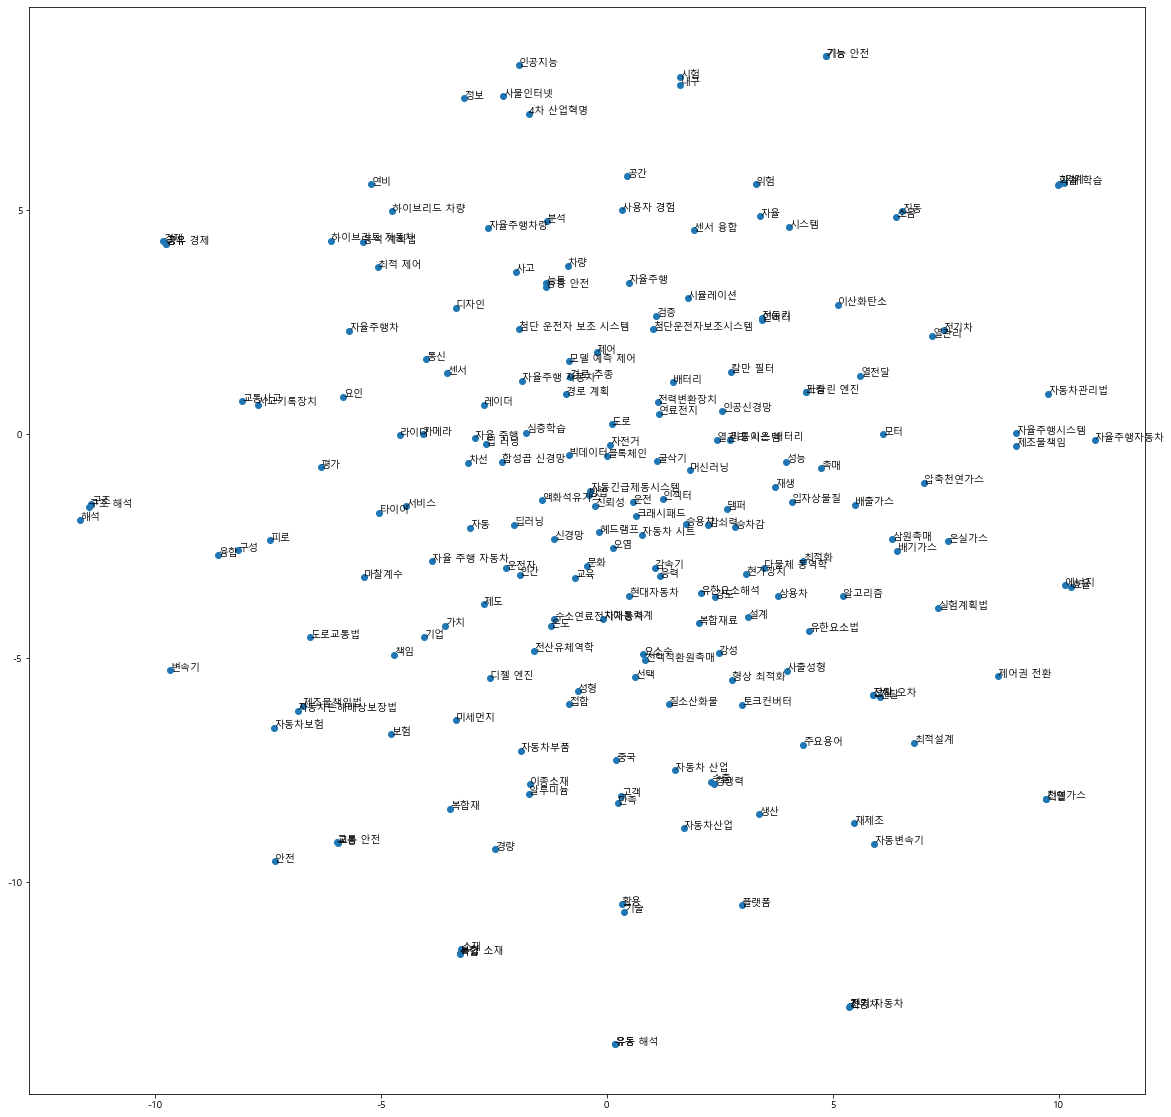

In [59]:
plt.figure(figsize=(20, 20))
plt.scatter(Z[:,0], Z[:,1])

#점에 text 붙히기
for i in range(len(vect.get_feature_names())):
    plt.annotate(s=vect.get_feature_names()[i].encode("utf8").decode("utf8"), xy=(Z[i,0], Z[i,1]))
plt.draw()
plt.savefig('tsne.png', dpi=600)

In [83]:
#수식이 필요함
#기관, 사람 도메인의 내용을 가지고 수식을 통해 연관성과 그렇지 않은 경우를 판단하여 지속적인 서비스를 제공해야함
#information 필터링/데이터 큐레이션

def find_analogies(w1, w2, w3, emb, word2idx):
    pos_word1 = emb[word2idx[w1]]
    pos_word2 = emb[word2idx[w2]]
    neg_word1 = emb[word2idx[w3]]
    v0 = pos_word1 + pos_word2 - neg_word1

    def dist1(a, b):
        return np.linalg.norm(a - b)
    def dist2(a, b):
        return 1 - a.dot(b) / (np.linalg.norm(a) * np.linalg.norm(b))

    for dist, name in [(dist1, 'Euclidean'), (dist2, 'cosine')]:
        min_dist = float('inf')
        best_word = ''
        for idx, word in enumerate(word2idx):
            if word not in (w1, w2, w3):
                v1 = emb[idx]
                d = dist(v0, v1)
                if d < min_dist:
                    min_dist = d
                    best_word = word
        print("closest match by", name, "distance:", best_word)
        print(w1, "-", w2, "=", w3, "-", best_word)

In [82]:
for word, idx in enumerate(word2idx) :
    print(word, idx)

0 4차 산업혁명
1 가솔린 엔진
2 가치
3 감속기
4 감쇠력
5 강도
6 강성
7 검증
8 경량
9 경로 계획
10 경로 추종
11 경쟁력
12 경제
13 고객
14 공간
15 공유
16 공유 경제
17 교육
18 교통
19 교통 안전
20 교통사고
21 구성
22 구조
23 구조 해석
24 굴삭기
25 기계
26 기계 학습
27 기능
28 기능 안전
29 기술
30 기업
31 내구
32 노킹
33 능동
34 능동 안전
35 다물체 동역학
36 댐퍼
37 도로
38 도로교통법
39 동적 계획법
40 디자인
41 디젤
42 디젤 엔진
43 딥 러닝
44 딥러닝
45 라이다
46 레이더
47 리튬이온 배터리
48 마찰계수
49 만족
50 머신러닝
51 모델 예측 제어
52 모터
53 문화
54 미세먼지
55 방법
56 배기가스
57 배출가스
58 배터리
59 변속기
60 보험
61 복합
62 복합 소재
63 복합재
64 복합재료
65 분석
66 블록체인
67 빅데이터
68 사고
69 사고기록장치
70 사물인터넷
71 사용자 경험
72 사출성형
73 삼원촉매
74 상용차
75 생산
76 서비스
77 선택
78 선택적환원촉매
79 설계
80 성능
81 성형
82 센서
83 센서 융합
84 소음
85 소재
86 수소연료전지자동차
87 수출
88 승용차
89 승차감
90 시뮬레이션
91 시스템
92 시험
93 신경망
94 신뢰성
95 실험계획법
96 심층학습
97 안전
98 알고리즘
99 알루미늄
100 압축천연가스
101 액화석유가스
102 에너지
103 연료전지
104 연비
105 열관리
106 열관리 시스템
107 열전달
108 오염
109 오차
110 온도
111 온실가스
112 요소수
113 요인
114 운전
115 운전자
116 위험
117 유동
118 유동 해석
119 유한요소법
120 유한요소해석
121 융합
122 응력
123 이산화탄소
124 이종소재
125 인간
126 인공신경망
127 인공지능
128 인버터
129 인젝터
130 입자상물질
131

In [99]:
#RFM
analogies_to_try = (
    ("자율주행","시스템","디젤"),
    ("댐퍼","융합","자율주행"),
)

word2idx = {word: ii for ii, word in enumerate(vect.get_feature_names())}
for word_list in analogies_to_try:
    print(word_list)
    w1, w2, w3 = word_list
    find_analogies(w1=w1, w2=w2, w3=w3, emb=Z, word2idx=word2idx)

('자율주행', '시스템', '디젤')
closest match by Euclidean distance: 인공지능
자율주행 - 시스템 = 디젤 - 인공지능
closest match by cosine distance: 사물인터넷
자율주행 - 시스템 = 디젤 - 사물인터넷
('댐퍼', '융합', '자율주행')
closest match by Euclidean distance: 교통 안전
댐퍼 - 융합 = 자율주행 - 교통 안전
closest match by cosine distance: 가치
댐퍼 - 융합 = 자율주행 - 가치


In [86]:
result.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [62]:
# 문장에서 뽑아낸 feature 들의 Dictionary
features = vect.get_feature_names()
print(features)

['4차 산업혁명', '가솔린 엔진', '가치', '감속기', '감쇠력', '강도', '강성', '검증', '경량', '경로 계획', '경로 추종', '경쟁력', '경제', '고객', '공간', '공유', '공유 경제', '교육', '교통', '교통 안전', '교통사고', '구성', '구조', '구조 해석', '굴삭기', '기계', '기계 학습', '기능', '기능 안전', '기술', '기업', '내구', '노킹', '능동', '능동 안전', '다물체 동역학', '댐퍼', '도로', '도로교통법', '동적 계획법', '디자인', '디젤', '디젤 엔진', '딥 러닝', '딥러닝', '라이다', '레이더', '리튬이온 배터리', '마찰계수', '만족', '머신러닝', '모델 예측 제어', '모터', '문화', '미세먼지', '방법', '배기가스', '배출가스', '배터리', '변속기', '보험', '복합', '복합 소재', '복합재', '복합재료', '분석', '블록체인', '빅데이터', '사고', '사고기록장치', '사물인터넷', '사용자 경험', '사출성형', '삼원촉매', '상용차', '생산', '서비스', '선택', '선택적환원촉매', '설계', '성능', '성형', '센서', '센서 융합', '소음', '소재', '수소연료전지자동차', '수출', '승용차', '승차감', '시뮬레이션', '시스템', '시험', '신경망', '신뢰성', '실험계획법', '심층학습', '안전', '알고리즘', '알루미늄', '압축천연가스', '액화석유가스', '에너지', '연료전지', '연비', '열관리', '열관리 시스템', '열전달', '오염', '오차', '온도', '온실가스', '요소수', '요인', '운전', '운전자', '위험', '유동', '유동 해석', '유한요소법', '유한요소해석', '융합', '응력', '이산화탄소', '이종소재', '인간', '인공신경망', '인공지능', '인버터', '인젝터', '입자상물질', '자동', '자동긴급제동시스템', '자동변

In [72]:
print(len(result.toarray()))

3001


In [36]:
result_frame = pd.DataFrame(result_array, columns=features)
result_frame

NameError: name 'result_array' is not defined

In [ ]:
last_result = pd.concat([dataset_3, result_frame.reindex(dataset_3.index)], axis = 1)
last_result

In [ ]:
dataset_3.to_csv("./dataset/count_vec.csv", index=False, encoding="utf-8")

In [ ]:
vectorize = TfidfVectorizer(
    tokenizer=tokenizer_by_mecab,
    min_df=5,
    sublinear_tf = True    # tf값에 1+log(tf)를 적용하여 tf값이 무한정 커지는 것을 막음
)
X = vectorize.fit_transform(rawdata)
print(
    'fit_transform, (sentence {}, feature {})'.format(X.shape[0], X.shape[1])
)
print(X.toarray())
# 문장에서 뽑아낸 feature 들의 배열
features = vectorize.get_feature_names()

In [ ]:
print(X.toarray())

### CountVector를 위한 준비 작업 및 확인 로직 (종료)

In [ ]:
result = []

for idx, val in enumerate(rawdata):
        if idx % 1000 == 0 :
        print(f'{idx + 1} 개를 처리중입니다. [{val}]')
    words = tokenizer_by_kkma(val)
    result.extend(words)

In [ ]:
len(result)

In [ ]:
count = Counter(result)

In [ ]:
words = dict(count.most_common(100))
print(words)


In [ ]:
words = dict(count.most_common(200))
print(words)

In [ ]:
dataset_5 = dataset_5.dropna()
for word in words :
    count = len(dataset_5[dataset_5['abstract'].str.contains(word)])
    print(f'주제어: {word} / 논문수: {count}')

In [ ]:
#키워드 를 축소 필요 
#키워드별로 논문 개수 (논문편수 5개 이하는 제외하자)
#https://codechacha.com/ko/python-google-translate/

- from googletrans import Translator
- translator = Translator()
- result = translator.translate('안녕하세요.', dest="ja")
- print(result[0].text)

#### 구글 번역 API가 변경되어 다음과 같은 설치 필요

- $ pip uninstall googletrans
- $ git clone https://github.com/alainrouillon/py-googletrans.git
- $ cd ./py-googletrans
- $ git checkout origin/feature/enhance-use-of-direct-api
- $ python setup.py install

In [ ]:
#1.주제어 COUNT
#2.분석대상 명확하게~ 
#3.주제어별 관계도